In [1]:
import random
from time import time
from neo4j import GraphDatabase
import pandas as pd

import mmh3
from collections import Counter

In [15]:
from tqdm import tqdm


small = True

USER = "neo4j"
PASSWD = "12345678"

AUTH = (USER, PASSWD)
DATABASE = "neo4j"
URI = f"bolt://localhost:7687"
       

random_query = "MATCH (t:Table) RETURN t.table_id, rand() as r ORDER BY r LIMIT 10"

query = """
    UNWIND $query_ids AS _query_id
    CALL {
        WITH _query_id
        MATCH (n:Table WHERE n.table_id = _query_id)-[r:HAS]->(t:Token)<-[p:HAS]-(m:Table WHERE m.table_id <> _query_id)
        RETURN n.table_id AS query_id, m.table_id AS result_id,
            SUM(
                CASE 
                    WHEN r.token_count >= p.token_count THEN p.token_count 
                    ELSE r.token_count 
                END
            ) AS token_count 
            ORDER BY token_count DESC 
            LIMIT 10
    }
    RETURN 
        query_id,
        result_id,
        token_count
"""

steps = []
results = []
s = 100
with GraphDatabase.driver(uri=URI, auth=AUTH) as driver:
    with driver.session(database=DATABASE) as session:
        query_ids = [x[0] for x in session.run(query=random_query).values()]
        
        for i in range(0, len(query_ids), s):
            start = time()
            results += session.run(query=query, parameters={"query_ids": query_ids[i:i+s]}).values()
            steps.append(time() - start)

df = pd.DataFrame(steps, columns=['time'])
df['time'] /= s
df.describe()

,time
count,1.000000
mean,0.022181
std,NaN
min,0.022181
25%,0.022181
50%,0.022181
75%,0.022181
max,0.022181


In [24]:
df = pd.DataFrame(results, columns=['query_id', 'result_id', 'token_count'])
df = df.pivot_table(values='token_count', index=['query_id', 'result_id'], aggfunc='sum').sort_values(by='token_count')
df

token_count
query_id result_id             
2047343  2147308              4
         2147019              4
         2078683              4
         2078680              4
         923374               4
...                         ...
1247756  958906              36
         2505077             36
         2157326             36
         717135              36
         1179463             39

[100 rows x 1 columns]

In [29]:
df = df.reset_index(level=['query_id', 'result_id'])

In [31]:
df[df['query_id'] == 2047343]

,query_id,result_id,token_count
0,2047343,2147308,4
1,2047343,2147019,4
2,2047343,2078683,4
3,2047343,2078680,4
4,2047343,923374,4
5,2047343,1117190,4
6,2047343,2653423,4
7,2047343,2078692,5
8,2047343,1744305,6
9,2047343,1741364,6


In [8]:
josie_res = pd.read_csv('/data4/nanni/tesi-magistrale/data/josie-tests/bigtest/results/base/ajosie_mbag_k10.csv')
# josie_res['duration'] /= 1000
josie_res['duration'].describe()

count    203.000000
mean      99.847291
std      119.364951
min        0.000000
25%       16.500000
50%       65.000000
75%      127.500000
max      832.000000
Name: duration, dtype: float64

In [9]:
josie_res['duration'].sum()

20269

array([[<Axes: title={'center': 'time'}>]], dtype=object)

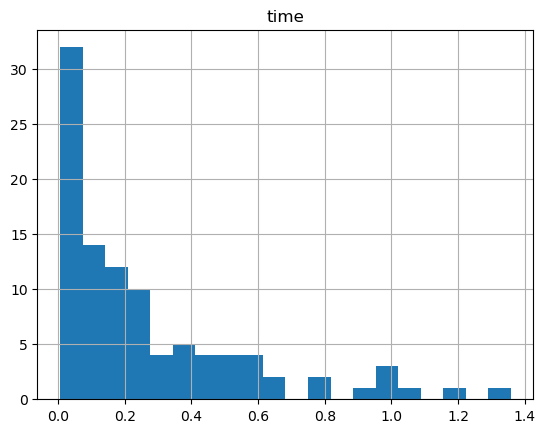

In [5]:
df.hist(column='time', bins=20)

In [36]:
# results = pd.DataFrame(results, columns=['query_id', 'token_count', 'result_id', 'token_id'])
results = pd.DataFrame(results, columns=['query_id', 'result_id', 'token_count'])

results

,query_id,result_id,token_count
0,889958,884711,11
1,889958,882024,10
2,889958,882907,10
3,889958,1387915,9
4,889958,1242790,8
5,889958,1242785,8
6,889958,882187,8
7,889958,2553148,7
8,889958,1828293,7
9,889958,2606051,7


In [37]:
results.pivot_table(values=['token_count'], index=['query_id', 'result_id'], aggfunc='sum').sort_values(by=['token_count'])

token_count
query_id result_id             
889958   1828293              7
         2553148              7
         2606051              7
         882187               8
         1242785              8
         1242790              8
         1387915              9
         882024              10
         882907              10
         884711              11

In [30]:
from tools.utils.utils import get_mongodb_collections


mongoclient, collections = get_mongodb_collections(small=False)

In [38]:
from tools.utils.utils import get_one_document_from_mongodb_by_key


tab1 = get_one_document_from_mongodb_by_key('_id_numeric', 1770653, *collections)
tab2 = get_one_document_from_mongodb_by_key('_id_numeric', 2153179, *collections)

In [39]:
def get_table_tokens_counter(table, numeric_columns):
    def prepare_token(token):
        return str(token).replace('|', ' ').replace('\n', ' ')

    tokens = [prepare_token(token) for row in table for icol, token in enumerate(row) 
                    if not pd.isna(token) and token and numeric_columns[icol] == 0]

    return Counter(tokens)

In [40]:
c1 = get_table_tokens_counter(tab1['content'], tab1['numeric_columns'])
c2 = get_table_tokens_counter(tab2['content'], tab2['numeric_columns'])

In [41]:
common = []
for tokid in set(c1.keys()).intersection(c2.keys()):
    common.append([tokid, c1[tokid], c2[tokid]])
common.append(['tot', 'tot', sum(min(x[1], x[2]) for x in common)])
pd.DataFrame(common)

,0,1,2
0,"New Delhi, India",18,16
1,tot,tot,16


In [42]:
pd.DataFrame(tab1['content'])

,0,1,2,3,4,5,6,7
0,Outcome,No.,Date,Tournament,Surface,Partner,Opponents,Score
1,Winner,1.,2 November 1998,"New Delhi, India",Hard,{{flagicon|IND}} Sai Jayalakshmy Jayaram,{{flagicon|THA}} Montika Anuchan\n{{flagicon|T...,"7–6(7–4), 1–6, 6–2"
2,Runner-up,2.,10 May 1999,"Lucknow, India",Carpet,{{flagicon|IND}} Sai Jayalakshmy Jayaram,{{flagicon|IND}} Shruti Dhawan\n{{flagicon|IND...,0–1 ret.
3,Runner-up,3.,18 October 1999,"Jakarta, Indonesia",Hard,{{flagicon|IND}} Sai Jayalakshmy Jayaram,{{flagicon|INA}} Liza Andriyani\n{{flagicon|TH...,"0–6, 3–6"
4,Winner,4.,16 April 2000,"Mumbai, India",Hard,{{flagicon|IND}} Sai Jayalakshmy Jayaram,{{flagicon|IND}} Manisha Malhotra\n{{flagicon|...,"6–4, 4–6, 2–1 Ret"
...,...,...,...,...,...,...,...,...
62,Runner-up,62.,20 June 2011,"New Delhi, India",Hard,{{flagicon|ISR}} Keren Shlomo,{{flagicon|KOR}} Kim Hae-sung\n{{flagicon|KOR}...,"5–7, 0–6"
63,Winner,63.,7 May 2012,"New Delhi, India",Hard,{{flagicon|IND}} Ankita Raina,{{flagicon|CHN}} Liu Yuxuan\n{{flagicon|China}...,"6–1, 6–4"
64,Winner,64.,21 May 2012,"New Delhi, India",Hard,{{flagicon|India}} Ankita Raina,{{flagicon|India}} Sri Peddy Reddy\n{{flagicon...,"6–3, 6–2"
65,Runner-up,65.,15 April 2013,"Chennai, India",Clay,{{flagicon|India}} Ankita Raina,{{flagicon|India}} Natasha Palha\n{{flagicon|I...,"7–5, 3–6, [6–10]"


In [43]:
pd.DataFrame(tab2['content'])

,0,1,2,3
0,SFL 2017: Finals - The Final Battle: Sher-E-Pu...,{{dts|format=dmy|2017|February|25}},Siri Fort Sports Complex,"New Delhi, India"
1,SFL 2017: Battle for Bronze - Bengaluru Tigers...,{{dts|format=dmy|2017|February|24}},Siri Fort Sports Complex,"New Delhi, India"
2,SFL 2017: Semifinals - The Ultimate Showdown: ...,{{dts|format=dmy|2017|February|18}},Siri Fort Sports Complex,"New Delhi, India"
3,SFL 2017: Semifinals - King of the Jungle: She...,{{dts|format=dmy|2017|February|17}},Siri Fort Sports Complex,"New Delhi, India"
4,SFL 2017: Gujarat Warriors vs. Goa Pirates,{{dts|format=dmy|2017|February|12}},Siri Fort Sports Complex,"New Delhi, India"
5,SFL 2017: Big City Brawl - Mumbai Maniacs vs. ...,{{dts|format=dmy|2017|February|11}},Siri Fort Sports Complex,"New Delhi, India"
6,SFL 2017: War of the North - Delhi Heroes vs. ...,{{dts|format=dmy|2017|February|10}},Siri Fort Sports Complex,"New Delhi, India"
7,SFL 2017: Battle of the Bold - U.P. Nawabs vs....,{{dts|format=dmy|2017|February|05}},Siri Fort Sports Complex,"New Delhi, India"
8,SFL 2017: Coastal Collision - Mumbai Maniacs v...,{{dts|format=dmy|2017|February|04}},Siri Fort Sports Complex,"New Delhi, India"
9,SFL 2017: Metro Mayhem - Gujarat Warriors vs. ...,{{dts|format=dmy|2017|February|03}},Siri Fort Sports Complex,"New Delhi, India"
